In [1]:
# =============================================================================
# bin/run_model.py
# @author: Brian Kyanjo
# @date: 2024-09-24
# @description: This script runs the flowline model using the EnKF data assimilation scheme.
# =============================================================================

In [2]:
# import libraries ========
import os
import sys
import jax
import warnings
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from scipy.optimize import root
from scipy.stats import norm, multivariate_normal

# parallel run with dask
import dask
from dask import delayed, compute

warnings.filterwarnings("ignore")
jax.config.update("jax_enable_x64", True) # Set the precision in JAX to use float64

In [3]:
main_directory = os.path.abspath(os.path.join(os.getcwd(), "../"))  # get the main directory
main_directory

'/Users/bkyanjo3/da_project/Data_assimilation_project'

In [4]:
# load necessary modules =========================
for path in [os.path.abspath('..'), os.path.abspath('../src')]:
    if path not in sys.path:
        sys.path.insert(0, path)

# Import necessary modules
from config.config_loader import ParamsLoader
from EnKF.python_enkf.enkf_class_python import EnsembleKalmanFilter
from utils.utils import UtilsFunctions
# from flowline_model.flowline_model import FlowlineModel
import flowline_model.flowline_model as flowline_model

import utils.tools as tools
cdir = os.getcwd()
tools.safe_chdir(main_directory,"../")

# Compile the Cython code
os.system("python src/EnKF/cython_enkf/setup.py")

# go back to current directory
os.chdir(cdir)

# import cythonized EnKF
from EnKF.cython_enkf.enkf import EnsembleKalmanFilter as CyEnKF

config_path = os.path.join(os.getcwd(), '../config', 'params.yaml') 

Compiling enkf.pyx because it changed.
[1/1] Cythonizing enkf.pyx


/Users/bkyanjo3/anaconda3/lib/python3.12/site-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /Users/bkyanjo3/da_project/Data_assimilation_project/src/EnKF/cython_enkf/enkf.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/Users/bkyanjo3/anaconda3/lib/python3.12/site-packages/setuptools/_distutils/dist.py:266: UserWarning: Unknown distribution option: 'compiler_directives'
  warnings.warn(msg)
In file included from enkf.c:1240:
In file included from /Users/bkyanjo3/anaconda3/lib/python3.12/site-packages/numpy/core/include/numpy/arrayobject.h:5:
In file included from /Users/bkyanjo3/anaconda3/lib/python3.12/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/bkyanjo3/anaconda3/lib/python3.12/site-packages/numpy/core/include/numpy/ndarraytypes.h:1929:
/Users/bkyanjo3/anaconda3/lib/python3.12/site-packages/numpy/core/include/n

running build
running build_ext
building 'EnKF.cython_enkf.enkf' extension
creating build
creating build/temp.macosx-11.1-arm64-cpython-312
clang -fno-strict-overflow -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /Users/bkyanjo3/anaconda3/include -arch arm64 -fPIC -O2 -isystem /Users/bkyanjo3/anaconda3/include -arch arm64 -I/Users/bkyanjo3/anaconda3/lib/python3.12/site-packages/numpy/core/include -I/Users/bkyanjo3/anaconda3/include/python3.12 -c enkf.c -o build/temp.macosx-11.1-arm64-cpython-312/enkf.o


1 warning generated.
ld: warning: duplicate -rpath '/Users/bkyanjo3/anaconda3/lib' ignored


creating EnKF
creating EnKF/cython_enkf
clang -bundle -undefined dynamic_lookup -Wl,-rpath,/Users/bkyanjo3/anaconda3/lib -L/Users/bkyanjo3/anaconda3/lib -Wl,-rpath,/Users/bkyanjo3/anaconda3/lib -L/Users/bkyanjo3/anaconda3/lib build/temp.macosx-11.1-arm64-cpython-312/enkf.o -o ./EnKF/cython_enkf/enkf.cpython-312-darwin.so


Step 1

Step 2

Step 3

Step 4

Step 5

Step 6

Step 7

Step 8

Step 9

Step 10

Step 11

Step 12

Step 13

Step 14

Step 15

Step 16

Step 17

Step 18

Step 19

Step 20

Step 21

Step 22

Step 23

Step 24

Step 25

Step 26

Step 27

Step 28

Step 29

Step 30

Step 31

Step 32

Step 33

Step 34

Step 35

Step 36

Step 37

Step 38

Step 39

Step 40

Step 41

Step 42

Step 43

Step 44

Step 45

Step 46

Step 47

Step 48

Step 49

Step 50

Step 51

Step 52

Step 53

Step 54

Step 55

Step 56

Step 57

Step 58

Step 59

Step 60

Step 61

Step 62

Step 63

Step 64

Step 65

Step 66

Step 67

Step 68

Step 69

Step 70

Step 71

Step 72

Step 73

Step 74

Step 75

Step 76

Step 77

Step 78

Step 79

Step 80

Step 81

Step 82

Step 83

Step 84

Step 85

Step 86

Step 87

Step 88

Step 89

Step 90

Step 91

Step 92

Step 93

Step 94

Step 95

Step 96

Step 97

Step 98

Step 99

Step 100

Step 101

Step 102

Step 103

Step 104

Step 105

Step 106

Step 107

Step 108

Step 109

Step 110

Step 111

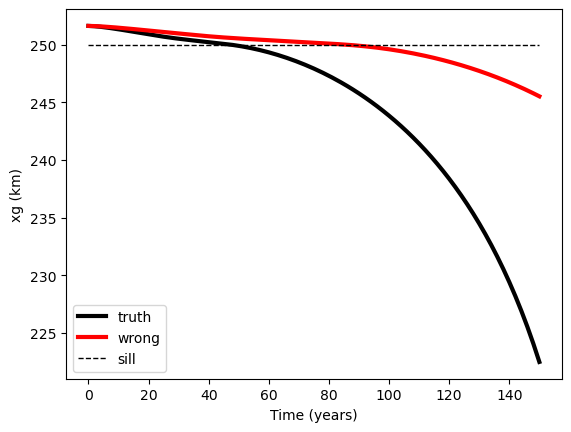

In [5]:
# Initial setup from the config file and initial guess ---------------
params = ParamsLoader(config_path).get_params()
grid = params['grid']

# Create instances of the necessary classes
utils_functions = UtilsFunctions(params)

# Initial guess and steady state ====================
xg = 300e3 / params["xscale"]
hf = (-utils_functions.bed(xg * params["xscale"]) / params["hscale"]) / (1 - params["lambda"])
h  = 1 - (1 - hf) * grid["sigma"]
u  = 1.0 * (grid["sigma_elem"] ** (1 / 3)) + 1e-3
huxg_old = np.concatenate((h, u, [xg]))

# Run the flowline model ====================
Jf = flowline_model.Jac_calc(huxg_old,params,grid,utils_functions.bed,flowline_model.flowline) # Jacobian of the model

# solve the system of equations
solve_result = root(
    lambda varin: flowline_model.flowline(varin,huxg_old,params,grid,utils_functions.bed), 
    huxg_old, 
    jac=Jf,
    method="hybr",
    options={"maxfev": 1000},
)
huxg_out0 = solve_result.x # extract the solution

# True simulation ====================
params["NT"] = 150
params["TF"] = params["year"] * 150
params["dt"] = params["TF"] / params["NT"]
params["transient"] = 1
params["facemelt"] = np.linspace(5, 85, params["NT"] + 1) / params["year"]
fm_dist = np.random.normal(0, 20.0)
fm_truth = params["facemelt"] 
params["facemelt"] = fm_truth

# Redefine the class instances with the new parameters
utils_functions = UtilsFunctions(params)

huxg_out1 = flowline_model.flowline_run(huxg_out0, params, grid, utils_functions.bed, flowline_model.flowline)


# Wrong simulation ====================
fm_wrong = np.linspace(5, 45, params["NT"] + 1) / params["year"]
params["facemelt"] = np.linspace(5, 45, params["NT"] + 1) / params["year"]

# Redefine the class instances with the new parameters
utils_functions = UtilsFunctions(params)
# flowline_model  =  FlowlineModel(params,grid,utils_functions.bed)

huxg_out2 = flowline_model.flowline_run(huxg_out0, params, grid, utils_functions.bed, flowline_model.flowline)

# Plot the results ====================
ts = np.linspace(0, params["TF"] / params["year"], params["NT"] + 1)

# xg_truth and xg_wrong calculations
xg_truth = np.concatenate(([huxg_out0[2 * params["NX"]]], huxg_out1[2 * params["NX"], :])) * params["xscale"]
xg_wrong = np.concatenate(([huxg_out0[2 * params["NX"]]], huxg_out2[2 * params["NX"], :])) * params["xscale"]

# Plotting the results
plt.plot(ts, xg_truth / 1e3, lw=3, color='black', label="truth")
plt.plot(ts, xg_wrong / 1e3, lw=3, color='red', label="wrong")
plt.plot(ts, 250.0 * np.ones_like(ts), lw=1, color='black', linestyle='--', label="sill")

# Add labels and legend
plt.xlabel("Time (years)")
plt.ylabel("xg (km)")
plt.legend()
plt.show()


In [6]:
# Set ensemble parameters ====================
statevec_init = np.concatenate((huxg_out0, [params["facemelt"][0] / params["uscale"]]))

# Dimension of model state
nd = statevec_init.shape[0]

# Number of ensemble members
N = 30

# Define the standard deviations for model, observation, and process noise
sig_model = 1e-1
sig_obs   = 1e-2
sig_Q     = 1e-2

# Initialize the Cov_model matrix
Cov_model = (sig_model**2) * np.eye(nd)

# Initialize the Q matrix
Q = (sig_Q**2) * np.eye(nd)

# Set model parameters for single time step runs
nt = params["NT"]
tfinal_sim = params["TF"]

ts = np.arange(0.0, params["NT"] + 1) * params["year"]

# Update parameters for a single time step run
params["NT"] = 1
params["TF"] = params["year"] * 1
params["dt"] = params["TF"] / params["NT"]
params["transient"] = 1
params["assim"] = True  

# Concatenate elements similar to Julia's vcat
statevec_sig = np.concatenate((grid["sigma_elem"], grid["sigma"], np.array([1, 1])))

taper = np.ones((statevec_sig.shape[0], statevec_sig.shape[0]))
taper[-1, -3] = 2  
taper[-3, -1] = 2  
taper[-1, -1] = 10  
taper[-2, -1] = 10  
taper[-1, -2] = 10  

# Generate synthetic observations of thickness from the "truth" simulation
ts_obs = np.arange(10.0, 140.0 + 1, 10.0) * params["year"]

# Find the indices of ts that match ts_obs (equivalent to findall(in(ts_obs), ts))
idx_obs = np.nonzero(np.isin(ts, ts_obs))[0]

# Define the observation noise distribution (equivalent to Normal(0, sig_obs) in Julia)
obs_dist = norm(loc=0, scale=sig_obs)

# Create virtual observations by vertically concatenating huxg_out1 and fm_truth with added noise
fm_truth_scaled = fm_truth[idx_obs] / params["uscale"]
huxg_virtual_obs = np.vstack((huxg_out1[:, idx_obs], fm_truth_scaled.T))

# Add random noise to the virtual observations
huxg_virtual_obs += obs_dist.rvs(size=huxg_virtual_obs.shape)

# Set the number of observations
params["m_obs"] = 10

# Initialize the Ensemble Kalman Filter ====================
statevec_bg = np.zeros((nd, nt + 1))        # Background state vector (ub)
statevec_ens_mean = np.zeros((nd, nt + 1))  # Ensemble mean state vector (ua)
mm_ens_mean = np.zeros((nd - 1, nt + 1))    # Ensemble mean minus one dimension (ua)
statevec_ens = np.zeros((nd, N))            # Individual ensemble members (uai)
statevec_ens_full = np.zeros((nd, N, nt + 1)) # Full ensemble for all timesteps (uae)

# Set initial conditions
statevec_bg[:, 0] = statevec_init
statevec_ens_mean[:, 0] = statevec_init

# Initialize the ensemble with perturbations
for i in range(N):
    # Sample from a multivariate normal distribution
    perturbed_state = multivariate_normal.rvs(mean=np.zeros(nd-1), cov=Cov_model[:-1, :-1])
    
    # Assign the perturbed state to the ensemble, excluding the last element
    statevec_ens[:-1, i] = statevec_init[:-1] + perturbed_state
    
    # Keep the last element unchanged
    statevec_ens[-1, i] = statevec_init[-1]

# Store the ensemble initialization for the first timestep
statevec_ens_full[:, :, 0] = statevec_ens

In [7]:
# forecast function for the EnKF ================================
def EnKF_forecast(k, N, statevec_bg, statevec_ens, params, grid, bedfun, modelfun, run_modelfun):
    """
    Function to perform the forecast step of the EnKF
    N - Number of ensemble members
    """

    # Update the background state vector
    statevec_bg[:-1, k+1] = np.squeeze(run_modelfun(statevec_bg[:-1, k], params, grid, bedfun, modelfun)) # background tracjectory (without correction)
    statevec_bg[-1, k+1] = params["facemelt"][k+1] / params["uscale"]

    # Ensemble forecast
    for i in range(N):
        huxg_temp = np.squeeze(run_modelfun(statevec_ens[:-1, i], params, grid, bedfun, modelfun))

        nos = np.random.multivariate_normal(np.zeros(nd), Q)  # Process noise

        # Update state ensemble with noise and forecast
        statevec_ens[:, i] = np.concatenate([huxg_temp, [params["facemelt"][k+1] / params["uscale"]]]) + nos

    # Compute the mean of the forcasts ensemble
    statevec_ens_mean[:, k+1] = np.mean(statevec_ens, axis=1)

    # Forecast error covariance matrix
    diff = statevec_ens - np.tile(statevec_ens_mean[:, k+1].reshape(-1, 1), N)
    Cov_model = (1/(N-1)) * diff @ diff.T

    return statevec_bg, statevec_ens, statevec_ens_mean, Cov_model

# forecast function for the DEnKF ==================================
def DEnKF_forecast(k, N, statevec_bg, statevec_ens, params, grid, bedfun, modelfun, run_modelfun):
    """
    Function to perform the forecast step of the DEnKF
    N - Number of ensemble members
    """

    # Update the background state vector
    statevec_bg[:-1, k+1] = np.squeeze(run_modelfun(statevec_bg[:-1, k], params, grid, bedfun, modelfun)) # background tracjectory (without correction)
    statevec_bg[-1, k+1] = params["facemelt"][k+1] / params["uscale"]

    # Ensemble forecast
    for i in range(N):
        huxg_temp = np.squeeze(run_modelfun(statevec_ens[:-1, i], params, grid, bedfun, modelfun))

        nos = np.random.multivariate_normal(np.zeros(nd), Q)  # Process noise

        # Update state ensemble with noise and forecast
        statevec_ens[:, i] = np.concatenate([huxg_temp, [params["facemelt"][k+1] / params["uscale"]]]) + nos

    # Compute the mean of the forcasts ensemble
    statevec_ens_mean[:, k+1] = np.mean(statevec_ens, axis=1)

    # Forecast error covariance matrix
    diff = statevec_ens - np.tile(statevec_ens_mean[:, k+1].reshape(-1, 1), N)
    Cov_model = (1/(N-1)) * diff @ diff.T

    return statevec_bg, statevec_ens, statevec_ens_mean, Cov_model

In [8]:
# Parallelized forecast function for the EnKF using Dask ==================
def EnKF_forecast_dask(k, N, statevec_bg, statevec_ens, params, grid, bedfun, modelfun, run_modelfun, nd, Q):
    """
    Function to perform the forecast step of the EnKF using Dask.
    
    k - Current time step index
    N - Number of ensemble members
    nd - Dimensionality of the noise vector
    Q - Covariance matrix for process noise
    """
    # Update the background state vector
    statevec_bg[:-1, k+1] = np.squeeze(run_modelfun(statevec_bg[:-1, k], params, grid, bedfun, modelfun))  # background trajectory
    statevec_bg[-1, k+1] = params["facemelt"][k+1] / params["uscale"]

    # Define a helper function to perform forecast for a single ensemble member
    def forecast_single_member_dask(i):
        huxg_temp = np.squeeze(run_modelfun(statevec_ens[:-1, i], params, grid, bedfun, modelfun))  # Forecast without correction
        nos = np.random.multivariate_normal(np.zeros(nd), Q)  # Process noise
        # Update state ensemble with noise and forecast
        return np.concatenate([huxg_temp, [params["facemelt"][k+1] / params["uscale"]]]) + nos

    # Create delayed tasks for Dask
    tasks = [delayed(forecast_single_member_dask)(i) for i in range(N)]

    # Compute all ensemble forecasts in parallel using Dask
    updated_ensemble = compute(*tasks)

    # Convert the result back to a numpy array
    statevec_ens = np.array(updated_ensemble).T  # Transpose to restore the correct shape

    # Compute the mean of the forecasted ensemble
    statevec_ens_mean[:, k+1] = np.mean(statevec_ens, axis=1)

    # Forecast error covariance matrix
    diff = statevec_ens - statevec_ens_mean[:, k+1].reshape(-1, 1)
    Cov_model = (1/(N-1)) * diff @ diff.T

    return statevec_bg, statevec_ens, statevec_ens_mean, Cov_model


In [9]:
# Run the Flowline model with the EnKF ====================
for k in range(nt):
    params["tcurrent"] = k + 1
    print(f"Step {k+1}\n")

    # Forecast step
    utils_functions = UtilsFunctions(params) # Redefine the class instances with the new parameters
    # serial version
    # statevec_bg, statevec_ens, statevec_ens_mean, Cov_model = EnKF_forecast(k, N, statevec_bg, statevec_ens, params, grid, utils_functions.bed, flowline_model.flowline, flowline_model.flowline_run)
    # parallel version
    statevec_bg, statevec_ens, statevec_ens_mean, Cov_model = EnKF_forecast_dask(k, N, statevec_bg, statevec_ens, params, grid, utils_functions.bed, flowline_model.flowline, flowline_model.flowline_run, nd, Q)

    # Check for observations at time step k+1
    if ts[k+1] in ts_obs:
        idx_obs = np.where(ts[k+1] == ts_obs)[0]

        # taper the covariance matrix
        Cov_model *= taper

        # Measurement noise covariance
        Cov_obs = (sig_obs**2) * np.eye(2 * params["m_obs"] + 1)

        # Subsample virtual observations to actual measurement locations
        huxg_obs = utils_functions.Obs(huxg_virtual_obs[:, idx_obs], params["m_obs"])

        # flatten huxg_obs
        huxg_obs = huxg_obs.ravel()

        # Analysis step
        # Create an instance for the ensemble Kalman filter class
        # enkf = EnsembleKalmanFilter(utils_functions.Obs, utils_functions.JObs, \
                                    # Cov_obs, Cov_model, taper, params, 
        # ensemble_threshold=30, n_jobs=-1)
        # enkf = EnsembleKalmanFilter(utils_functions.Obs, utils_functions.JObs, \
        #                            Cov_obs, Cov_model, taper, params)
        enkf = CyEnKF(utils_functions.Obs, utils_functions.JObs, \
                                    Cov_obs, Cov_model, taper, params) # Cythonized EnKF
        # Analysis corrections
        # statevec_ens_temp, Cov_model = enkf.EnKF_analyze(statevec_ens,huxg_obs)
        statevec_ens_temp, Cov_model = enkf.analyze(statevec_ens, huxg_obs)

        statevec_ens = statevec_ens_temp
        statevec_ens_mean[:, k+1] = np.mean(statevec_ens, axis=1)

        # Inflate ensemble spread
        statevec_ens = np.tile(statevec_ens_mean[:, k+1].reshape(-1, 1), N) + params["inflation"] * (statevec_ens - np.tile(statevec_ens_mean[:, k+1].reshape(-1, 1), N))

        # Update facemelt parameter for future steps
        params["facemelt"][k+1:] = statevec_ens_mean[-1, k+1] * params["uscale"] * np.ones_like(params["facemelt"][k+1:])

    # Store full ensemble for the current time step
    statevec_ens_full[:, :, k+1] = statevec_ens


Step 1

Step 2

Step 3

Step 4

Step 5

Step 6

Step 7

Step 8

Step 9

Step 10

Step 11

Step 12



In [9]:
# # Run the Flowline model with the EnKF ====================
# for k in range(nt):
#     params["tcurrent"] = k + 1
#     print(f"Step {k+1}\n")

#     # Forecast step
#     statevec_bg[:-1, k+1] = np.squeeze(flowline_model.flowline_run(statevec_bg[:-1, k], params, grid, utils_functions.bed, flowline_model.flowline)) # background tracjectory (without correction)

#     statevec_bg[-1, k+1] = params["facemelt"][k+1] / params["uscale"]

#     # Ensemble forecast
#     for i in range(N):
#         huxg_temp = np.squeeze(flowline_model.flowline_run(statevec_ens[:-1, i], params, grid, utils_functions.bed, flowline_model.flowline))

#         nos = np.random.multivariate_normal(np.zeros(nd), Q)  # Process noise

#         # Update state ensemble with noise and forecast
#         statevec_ens[:, i] = np.concatenate([huxg_temp, [params["facemelt"][k+1] / params["uscale"]]]) + nos

#     # Compute the mean of the analysis ensemble
#     statevec_ens_mean[:, k+1] = np.mean(statevec_ens, axis=1)

#     # Check for observations at time step k+1
#     if ts[k+1] in ts_obs:
#         idx_obs = np.where(ts[k+1] == ts_obs)[0]

#         # Forecast error covariance matrix
#         diff = statevec_ens - np.tile(statevec_ens_mean[:, k+1].reshape(-1, 1), N)
#         Cov_model = (1/(N-1)) * diff @ diff.T
#         Cov_model *= taper

#         # Measurement noise covariance
#         Cov_obs = (sig_obs**2) * np.eye(2 * params["m_obs"] + 1)

#         # Subsample virtual observations to actual measurement locations
#         utils_functions = UtilsFunctions(params) # Redefine the class instances with the new parameters
#         huxg_obs = utils_functions.Obs(huxg_virtual_obs[:, idx_obs], params["m_obs"])

#         # flatten huxg_obs
#         huxg_obs = huxg_obs.ravel()

#         # Create an instance for the ensemble Kalman filter class
#         # enkf = EnsembleKalmanFilter(utils_functions.Obs, utils_functions.JObs, \
#         #                             Cov_obs, Cov_model, taper, params, 
#         # ensemble_threshold=30, n_jobs=-1)
#         enkf = EnsembleKalmanFilter(utils_functions.Obs, utils_functions.JObs, \
#                                    Cov_obs, Cov_model, taper, params)
#         # Analysis corrections
#         statevec_ens_temp, Cov_model = enkf.EnKF_analyze(statevec_ens,huxg_obs)
#         # statevec_ens_temp, Cov_model = enkf.analyze(statevec_ens, huxg_obs)

#         statevec_ens = statevec_ens_temp
#         statevec_ens_mean[:, k+1] = np.mean(statevec_ens, axis=1)

#         # Inflate ensemble spread
#         statevec_ens = np.tile(statevec_ens_mean[:, k+1].reshape(-1, 1), N) + params["inflation"] * (statevec_ens - np.tile(statevec_ens_mean[:, k+1].reshape(-1, 1), N))

#         # Update facemelt parameter for future steps
#         params["facemelt"][k+1:] = statevec_ens_mean[-1, k+1] * params["uscale"] * np.ones_like(params["facemelt"][k+1:])

#     # Store full ensemble for the current time step
#     statevec_ens_full[:, :, k+1] = statevec_ens
nt

150

In [10]:
# # Run the Flowline model with the EnKF ====================
# def parallel_forecast_step(i, nd, statevec_ens, params, grid, bedfun, flowlinefun, flowline_runfun,Q):
#     """
#     Parallelized forecast step for a single ensemble member.
    
#     Parameters:
#     i: int - Ensemble member index.
#     statevec_ens: ndarray - State ensemble.
#     params, grid, bedfun, flowlinefun: Model parameters and functions.
#     Q: ndarray - Process noise covariance matrix.
    
#     Returns:
#     Updated state ensemble for member i.
#     """
#     # Run the flowline model for this ensemble member
#     huxg_temp = np.squeeze(flowline_runfun(statevec_ens[:-1, i], params, grid, bedfun, flowlinefun))
    
#     # Generate process noise
#     nos = np.random.multivariate_normal(np.zeros(nd), Q)

#     # Update state ensemble with noise and forecast
#     updated_state = np.concatenate([huxg_temp, [params["facemelt"][params["tcurrent"]] / params["uscale"]]]) + nos
#     return updated_state

# # Main loop with dask parallelization
# for k in range(nt):
#     params["tcurrent"] = k + 1
#     print(f"Step {k+1}\n")

#     utils_functions = UtilsFunctions(params)  # Redefine the class instances with the new parameters

#     # Forecast step for the background trajectory
#     statevec_bg[:-1, k+1] = np.squeeze(flowline_model.flowline_run(statevec_bg[:-1, k], params, grid, utils_functions.bed, flowline_model.flowline))
#     statevec_bg[-1, k+1] = params["facemelt"][k+1] / params["uscale"]

#     # Parallelized Ensemble forecast using Dask
#     tasks = [delayed(parallel_forecast_step)(i, nd, statevec_ens, params, grid, utils_functions.bed, flowline_model.flowline,flowline_model.flowline_run, Q) for i in range(N)]
#     results = compute(*tasks)

#     # Collect results into statevec_ens
#     statevec_ens = np.column_stack(results)

#     # Compute the mean of the analysis ensemble
#     statevec_ens_mean[:, k+1] = np.mean(statevec_ens, axis=1)

#     # Check for observations at time step k+1
#     if ts[k+1] in ts_obs:
#         idx_obs = np.where(ts[k+1] == ts_obs)[0]

#         # Forecast error covariance matrix
#         diff = statevec_ens - np.tile(statevec_ens_mean[:, k+1].reshape(-1, 1), N)
#         Cov_model = (1/(N-1)) * diff @ diff.T
#         Cov_model *= taper

#         # Measurement noise covariance
#         Cov_obs = (sig_obs**2) * np.eye(2 * params["m_obs"] + 1)

#         # Subsample virtual observations to actual measurement locations
#         huxg_obs = utils_functions.Obs(huxg_virtual_obs[:, idx_obs], params["m_obs"])

#         # Flatten huxg_obs
#         huxg_obs = huxg_obs.ravel()

#         # Create an instance for the ensemble Kalman filter class
#         enkf = EnsembleKalmanFilter(utils_functions.Obs, utils_functions.JObs, Cov_obs, Cov_model, taper, params)

#         # Analysis corrections using the EnKF
#         statevec_ens, Cov_model = enkf.analyze(statevec_ens, huxg_obs)

#         statevec_ens_mean[:, k+1] = np.mean(statevec_ens, axis=1)

#         # Inflate ensemble spread
#         statevec_ens = np.tile(statevec_ens_mean[:, k+1].reshape(-1, 1), N) + params["inflation"] * (statevec_ens - np.tile(statevec_ens_mean[:, k+1].reshape(-1, 1), N))

#         # Update facemelt parameter for future steps
#         params["facemelt"][k+1:] = statevec_ens_mean[-1, k+1] * params["uscale"] * np.ones_like(params["facemelt"][k+1:])

#     # Store full ensemble for the current time step
#     statevec_ens_full[:, :, k+1] = statevec_ens


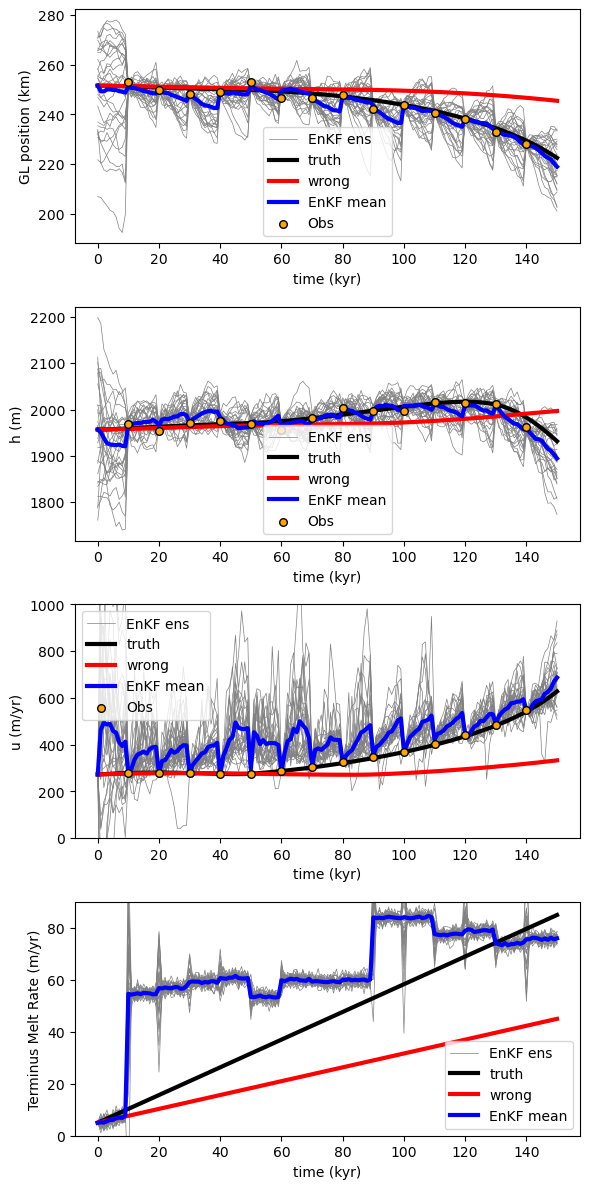

In [11]:
# Plotting the results ====================
fig, axes = plt.subplots(4, 1, figsize=(6, 12))

utils_functions = UtilsFunctions(params) # Redefine the class instances with the new parameters
huxg_obs = utils_functions.Obs(huxg_virtual_obs, params["m_obs"])

# 1. Plot Grounding Line (GL) position
xg_idx = 2 * params["NX"] 
xg_truth = np.concatenate(([huxg_out0[xg_idx]], huxg_out1[xg_idx, :])) * params["xscale"]
xg_wrong = np.concatenate(([statevec_init[xg_idx]], huxg_out2[xg_idx, :])) * params["xscale"]
xg_EnKF_ens_mean = statevec_ens_mean[xg_idx, :] * params["xscale"]
xg_EnKF_ens = statevec_ens_full[xg_idx, :, :].T * params["xscale"]
xg_obs = huxg_obs[-1, :] * params["xscale"]

for i in range(xg_EnKF_ens.shape[1]):
    axes[0].plot(ts / params["year"], xg_EnKF_ens[:, i] / 1e3, lw=0.5, color='gray', label="EnKF ens" if i == 0 else "")

axes[0].plot(ts / params["year"], xg_truth / 1e3, lw=3, color='black', label='truth')
axes[0].plot(ts / params["year"], xg_wrong / 1e3, lw=3, color='red', label='wrong')
axes[0].plot(ts / params["year"], xg_EnKF_ens_mean / 1e3, lw=3, color='blue', label='EnKF mean')
axes[0].scatter(ts_obs / params["year"], xg_obs / 1e3, color='orange', s=30, edgecolor='black', label='Obs', zorder=3)
axes[0].set_xlabel("time (kyr)")
axes[0].set_ylabel("GL position (km)")
axes[0].legend(loc='best')

# Save the first plot as a separate figure
fig1, ax1 = plt.subplots()
ax1.plot(ts / params["year"], xg_truth / 1e3, lw=3, color='black', label='truth')
ax1.plot(ts / params["year"], xg_wrong / 1e3, lw=3, color='red', label='wrong')
ax1.plot(ts / params["year"], xg_EnKF_ens_mean / 1e3, lw=3, color='blue', label='EnKF mean')
ax1.scatter(ts_obs / params["year"], xg_obs / 1e3, color='orange', s=30, edgecolor='black', label='Obs', zorder=3)
ax1.set_xlabel("time (kyr)")
ax1.set_ylabel("GL position (km)")
ax1.legend(loc='best')
fig1.savefig("GL_position.png", dpi=300)
plt.close(fig1)

# 2. Plot h mid-profile
index_h = 25 
h_truth = np.concatenate(([huxg_out0[index_h]], huxg_out1[index_h, :])) * params["hscale"]
h_wrong = np.concatenate(([statevec_init[index_h]], huxg_out2[index_h, :])) * params["hscale"]
h_EnKF_ens_mean = statevec_ens_mean[index_h, :] * params["hscale"]
h_EnKF_ens = statevec_ens_full[index_h, :, :].T * params["hscale"]
h_obs = huxg_virtual_obs[index_h, :] * params["hscale"]

for i in range(h_EnKF_ens.shape[1]):  # Loop over ensemble members
    axes[1].plot(ts / params["year"], h_EnKF_ens[:, i], lw=0.5, color='gray', label="EnKF ens" if i == 0 else "")
axes[1].plot(ts / params["year"], h_truth, lw=3, color='black', label='truth')
axes[1].plot(ts / params["year"], h_wrong, lw=3, color='red', label='wrong')
axes[1].plot(ts / params["year"], h_EnKF_ens_mean, lw=3, color='blue', label='EnKF mean')
axes[1].scatter(ts_obs / params["year"], h_obs, color='orange', s=30, edgecolor='black', label='Obs', zorder=3)
axes[1].set_xlabel("time (kyr)")
axes[1].set_ylabel("h (m)")
axes[1].legend(loc='best')

# 3. Plot u at terminus
index_ut = 100 -1
u_truth = np.concatenate(([huxg_out0[index_ut]], huxg_out1[index_ut, :])) * params["uscale"] * params["year"]
u_wrong = np.concatenate(([statevec_init[index_ut]], huxg_out2[index_ut, :])) * params["uscale"] * params["year"]
u_EnKF_ens_mean = statevec_ens_mean[index_ut, :] * params["uscale"] * params["year"]
u_EnKF_ens = statevec_ens_full[index_ut, :, :].T * params["uscale"] * params["year"]
u_obs = huxg_virtual_obs[index_ut, :] * params["uscale"] * params["year"]

for i in range(u_EnKF_ens.shape[1]):  # Loop over ensemble members
    axes[2].plot(ts / params["year"], u_EnKF_ens[:, i], lw=0.5, color='gray', label="EnKF ens" if i == 0 else "")

axes[2].plot(ts / params["year"], u_truth, lw=3, color='black', label='truth')
axes[2].plot(ts / params["year"], u_wrong, lw=3, color='red', label='wrong')
axes[2].plot(ts / params["year"], u_EnKF_ens_mean, lw=3, color='blue', label='EnKF mean')
axes[2].scatter(ts_obs / params["year"], u_obs, color='orange', s=30, edgecolor='black', label='Obs', zorder=3)
axes[2].set_xlabel("time (kyr)")
axes[2].set_ylabel("u (m/yr)")
axes[2].set_ylim(0, 1000)
axes[2].legend(loc='best')

# 4. Plot terminus melt
fm_EnKF_ens_mean = statevec_ens_mean[-1, :] * params["uscale"] * params["year"]
fm_EnKF_ens = statevec_ens_full[-1, :, :].T * params["uscale"] * params["year"]

# Plot the ensemble (gray lines) on the 4th subplot
for i in range(fm_EnKF_ens.shape[1]):  # Loop over ensemble members
    axes[3].plot(ts / params["year"], fm_EnKF_ens[:, i], lw=0.5, color='gray', label="EnKF ens" if i == 0 else "")
axes[3].plot(ts / params["year"], fm_truth * params["year"], lw=3, color='black', label='truth')
axes[3].plot(ts / params["year"], fm_wrong * params["year"], lw=3, color='red', label='wrong')
axes[3].plot(ts / params["year"], fm_EnKF_ens_mean, lw=3, color='blue', label='EnKF mean')
axes[3].set_xlabel("time (kyr)")
axes[3].set_ylabel("Terminus Melt Rate (m/yr)")
axes[3].set_ylim(0, 90)
axes[3].legend(loc='best')

plt.tight_layout()
plt.show()